In [46]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
import pyk4a
from pyk4a import Config, PyK4A

k4a = PyK4A(
    Config(
        color_resolution=pyk4a.ColorResolution.RES_720P,
        depth_mode=pyk4a.DepthMode.NFOV_UNBINNED,
        synchronized_images_only=True,
    )
)
k4a.start()

# getters and setters directly get and set on device
k4a.whitebalance = 4500
assert k4a.whitebalance == 4500
k4a.whitebalance = 4510
assert k4a.whitebalance == 4510

capture = k4a.get_capture()
color = capture.color
depth = capture.transformed_depth
k4a.stop()

In [160]:
# remove alpha channel
depth = torch.tensor(depth.astype(float), dtype=torch.float)
depth = depth[None, None, ...]

color = torch.tensor(color.astype(float), dtype=torch.float)
color = color[None, ..., :3].permute(0, 3, 1, 2)

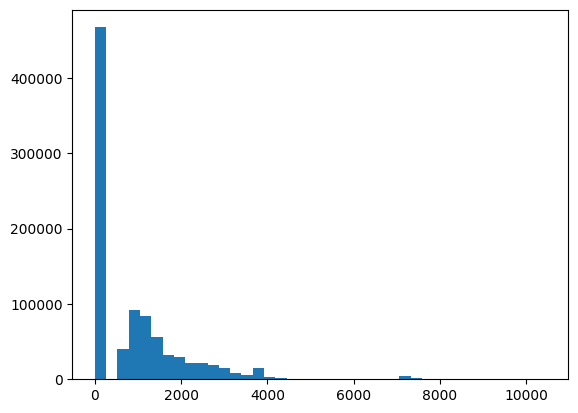

In [161]:
# visualize depth distribution
_ = plt.hist(depth.flatten(), bins=40)

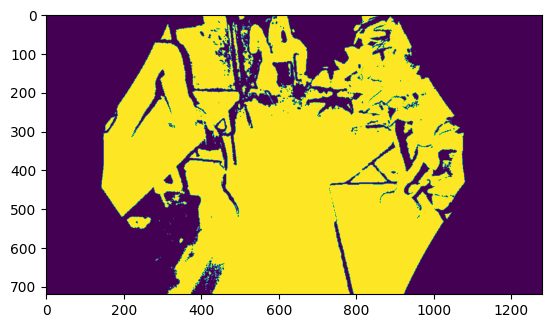

In [162]:
mask = (depth > 10.0) * (depth < 5000.0)

# visualize image mask
mask_img = mask[0,0,...].numpy()
mask_img = mask_img.astype(float)
_ = plt.imshow(mask_img)

# reshape depth image
mask = torch.tile(mask, [1, 3, 1, 1])

In [15]:
from camera import Camera
from options import Options 
from dataset import CustomDataset

In [171]:
opt = Options()
defaults = opt.parser.parse_args([])
defaults.height = 720
defaults.width = 1280

cam = Camera(defaults)

In [173]:
optimizer = torch.optim.Adam(cam.parameters(), lr=1e-2)
lossFunction = torch.nn.MSELoss()

In [176]:
print("Continue optimizing throughout trajectory")

loss_lst = []
for i in range(0, 50):
    optimizer.zero_grad()
    predColor = cam(depth, color)
    loss = lossFunction(predColor[mask], color[mask])
    loss.backward()
    optimizer.step()
    print("loss:", loss.data)
    loss_lst.append(loss.item())
    print("color extrinsics:", cam.colorE.data)

Continue optimizing throughout trajectory
loss: tensor(2658.2966)
color extrinsics: tensor([[[ 1.0169e+00,  2.0522e-03,  5.1826e-03,  2.1273e-02],
         [-4.8477e-03,  1.0200e+00, -3.4492e-04, -3.9830e-02],
         [ 6.4919e-03, -8.7814e-03,  9.9192e-01, -1.9102e-02],
         [-4.8370e-02,  2.0118e-02,  3.2047e-02,  1.0012e+00]]])
loss: tensor(3590.7004)
color extrinsics: tensor([[[ 1.0157e+00,  1.5314e-03,  3.7147e-03,  2.0438e-02],
         [-5.1813e-03,  1.0199e+00, -4.9051e-04, -4.0801e-02],
         [ 7.4682e-03, -8.2506e-03,  9.9302e-01, -1.8472e-02],
         [-5.0256e-02,  1.7652e-02,  2.9249e-02,  9.9862e-01]]])
loss: tensor(3882.9517)
color extrinsics: tensor([[[ 1.0152e+00,  1.7622e-03,  3.0886e-03,  2.0372e-02],
         [-4.9367e-03,  1.0206e+00,  1.5624e-04, -4.0969e-02],
         [ 7.8660e-03, -8.4664e-03,  9.9337e-01, -1.8562e-02],
         [-5.1362e-02,  1.6248e-02,  2.7519e-02,  9.9707e-01]]])
loss: tensor(3939.1113)
color extrinsics: tensor([[[ 1.0152,  0.0027, 

loss: tensor(3419.3110)
color extrinsics: tensor([[[ 1.0278, -0.0222,  0.0015,  0.0267],
         [-0.0028,  1.0285,  0.0066, -0.0669],
         [-0.0054, -0.0031,  0.9861, -0.0362],
         [-0.0433,  0.0299,  0.0364,  1.0061]]])
loss: tensor(2008.0037)
color extrinsics: tensor([[[ 1.0248e+00, -2.5763e-02, -1.7772e-03,  2.3936e-02],
         [-5.0282e-03,  1.0258e+00,  3.4949e-03, -7.1038e-02],
         [-2.6368e-03,  1.9236e-04,  9.8926e-01, -3.3450e-02],
         [-4.0447e-02,  3.3021e-02,  3.9611e-02,  1.0090e+00]]])
loss: tensor(2555.8958)
color extrinsics: tensor([[[ 1.0238, -0.0275, -0.0033,  0.0231],
         [-0.0058,  1.0245,  0.0019, -0.0735],
         [-0.0018,  0.0016,  0.9906, -0.0326],
         [-0.0388,  0.0350,  0.0417,  1.0107]]])
loss: tensor(3454.9551)
color extrinsics: tensor([[[ 1.0239, -0.0279, -0.0035,  0.0236],
         [-0.0060,  1.0240,  0.0011, -0.0752],
         [-0.0019,  0.0020,  0.9909, -0.0330],
         [-0.0378,  0.0364,  0.0431,  1.0117]]])
loss: te

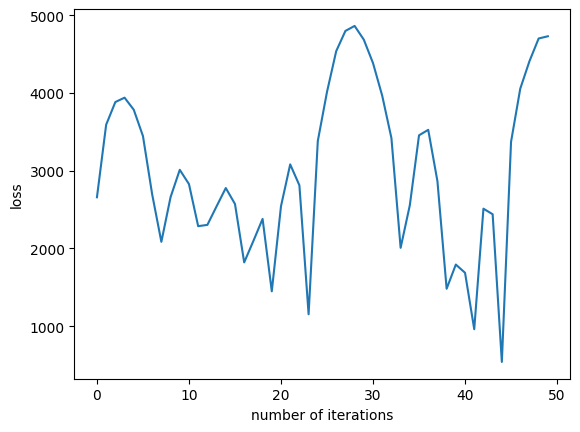

In [179]:
# plot change of the loss
plt.xlabel('number of iterations')
plt.ylabel('loss')
_ = plt.plot(loss_lst)

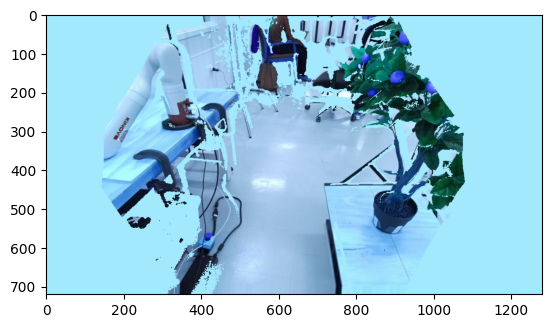

In [175]:
predImg = predColor.detach().numpy()
predImg = predImg[0, :, :, :].transpose(1, 2, 0)
predImg = np.round(predImg).astype(int)
_ = plt.imshow(predImg)